In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt # For data viz
import pandas as pd
import numpy as np

data= pd.read_csv('aligned_output.csv')
data

,Time,No. of Cases,Turbidity
0,"Saturday, December 31, 2022 12:00:00 A.M.",0.0,20
1,"Saturday, December 31, 2022 3:00:00 A.M.",6.0,15
2,"Saturday, December 31, 2022 6:00:00 A.M.",1.0,19
3,"Saturday, December 31, 2022 9:00:00 A.M.",0.0,12
4,"Saturday, December 31, 2022 12:00:00 P.M.",1.0,5
...,...,...,...
461,"Wednesday, December 27, 2023",0.0,1
462,"Thursday, December 28, 2023",0.0,3
463,"Friday, December 29, 2023",0.0,2
464,"Saturday, December 30, 2023",0.0,1


In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

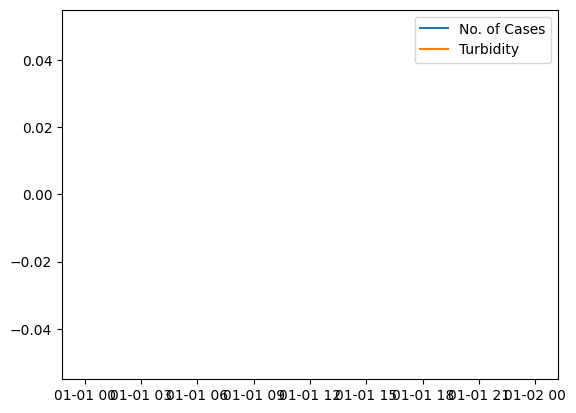

In [ ]:
data['Time']= pd.to_datetime(data['Time'])
plt.plot(data['Time'], data['No. of Cases'])

In [ ]:
from copy import deepcopy as dc 

def prepare_dataframe_for_lstm(df, n_steps):
    df= dc(df)
    
    
    df.set_index('Time', inplace=True)
    
    for i in range(1, n_steps+1):
        df[f'No. of Cases{i}']= df['No. of Cases'].shift(i)
        
        
        
    df.dropna(inplace=True)
    return df

lookback= 7
shifted_data= prepare_dataframe_for_lstm(data, lookback)
shifted_data.head()

,No. of Cases,Turbidity,No. of Cases1,Turbidity1,No. of Cases2,Turbidity2,No. of Cases3,Turbidity3,No. of Cases4,Turbidity4,No. of Cases5,Turbidity5,No. of Cases6,Turbidity6,No. of Cases7,Turbidity7
Time,,,,,,,,,,,,,,,,


In [34]:
shifted_df_as_numpy= shifted_data.to_numpy()
shifted_df_as_numpy


array([], shape=(0, 16), dtype=float64)

In [36]:
from sklearn.preprocessing import MinMaxScaler
scaler= MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_numpy= scaler.fit_transform(shifted_df_as_numpy)
shifted_df_as_numpy

ValueError: Found array with 0 sample(s) (shape=(0, 16)) while a minimum of 1 is required by MinMaxScaler.

In [37]:
x= shifted_df_as_numpy[:, 1:]
y= shifted_df_as_numpy[:, 0]

x.shape, y.shape

((0, 15), (0,))

In [ ]:
x= dc(np.flip(x, axis=1))
x

array([[-0.2       , -1.        , -0.4       , ..., -0.92      ,
        -0.6       , -0.2       ],
       [-0.4       ,  1.        , -0.24      , ..., -0.2       ,
        -0.6       , -0.28      ],
       [-0.24      , -0.66666667, -0.52      , ..., -0.28      ,
        -0.2       , -0.2       ],
       ...,
       [-0.92      , -1.        , -0.92      , ..., -0.88      ,
        -1.        , -0.92      ],
       [-0.92      , -1.        , -0.88      , ..., -0.92      ,
        -1.        , -0.96      ],
       [-0.88      , -1.        , -0.88      , ..., -0.96      ,
        -1.        , -1.        ]])

In [ ]:
split= int(0.95 * len(x))
split

420

In [38]:
x_train= x[:split]
x_test= x[split:]
y_train= y[:split]
y_test= y[split:]
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((0, 15), (0,), (0, 15), (0,))

In [39]:
X_train = x_train.reshape((-1, lookback, 1))
X_test = x_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))
X_train.shape, X_test.shape, y_train. shape, y_test.shape

((0, 7, 1), (0, 7, 1), (0, 1), (0, 1))

In [ ]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test= torch.tensor(X_test).float()
y_test =torch.tensor(y_test).float()
X_train.shape, X_test.shape, y_train. shape, y_test.shape

(torch.Size([420, 7, 1]),
 torch.Size([23, 7, 1]),
 torch.Size([420, 1]),
 torch.Size([23, 1]))

In [ ]:
from torch.utils.data import Dataset 

class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        self.x= x
        self.y= y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train_ds= TimeSeriesDataset(X_train, y_train)
test_ds= TimeSeriesDataset(X_test, y_test)

In [ ]:
train_ds

In [ ]:
from torch.utils.data import DataLoader

batch_size= 16

train_loader= DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader= DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [ ]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch= batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.lstm = nn. LSTM(input_size, hidden_size, num_stacked_layers,
        batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
model = LSTM(1,4,1).to(device)
model   

LSTM(
  (lstm): LSTM(2, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=2, bias=True)
)


In [ ]:
def train_one_epoch():
    model.train (True)
    print('Epoch: {epoch + 1}')
    running_loss= 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch= batch[0].to(device), batch [1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()
        
        if batch_index % 10 == 9: # print every 100 batches
            avg_loss_across_batches= running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,avg_loss_across_batches))
            running_loss = 0.0
print()

In [ ]:
def validate_one_epoch():
    model.train (False)
    running_loss= 0.0
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch=batch[0].to(device), batch [1].to(device)
        with torch.no_grad():
            output= model(x_batch)
            loss= loss_function(output, y_batch)
            running_loss += loss
    avg_loss_across_batches = running_loss / len(test_loader)
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('******************************')
    print()

In [ ]:
learning_rate=0.001
num_epochs = 40
loss_function = nn.MSELoss()
optimizer = torch.optim. Adam (model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: {epoch + 1}
Batch 10, Loss: 0.022
Batch 20, Loss: 0.020
Val Loss: 0.164
******************************

Epoch: {epoch + 1}
Batch 10, Loss: 0.016
Batch 20, Loss: 0.015
Val Loss: 0.091
******************************

Epoch: {epoch + 1}
Batch 10, Loss: 0.014
Batch 20, Loss: 0.011
Val Loss: 0.040
******************************

Epoch: {epoch + 1}
Batch 10, Loss: 0.011
Batch 20, Loss: 0.008
Val Loss: 0.017
******************************

Epoch: {epoch + 1}
Batch 10, Loss: 0.008
Batch 20, Loss: 0.010
Val Loss: 0.012
******************************

Epoch: {epoch + 1}
Batch 10, Loss: 0.010
Batch 20, Loss: 0.010
Val Loss: 0.011
******************************

Epoch: {epoch + 1}
Batch 10, Loss: 0.008
Batch 20, Loss: 0.013
Val Loss: 0.010
******************************

Epoch: {epoch + 1}
Batch 10, Loss: 0.009
Batch 20, Loss: 0.011
Val Loss: 0.011
******************************

Epoch: {epoch + 1}
Batch 10, Loss: 0.009
Batch 20, Loss: 0.008
Val Loss: 0.009
******************************

E

In [ ]:
# CORRECTED CELL 19 (Plotting Predictions)

# Put model in evaluation mode
model.eval()

with torch.no_grad():
    # Make predictions on the training data to see how well it learned
    predicted = model(X_train.to(device)).to('cpu').numpy()

# Plot the actual vs predicted values for 'No. of Cases'
plt.plot(y_train[:, 0], label='Actual Cases')
plt.plot(predicted[:, 0], label='Predicted Cases')
plt.title('Training Data: No. of Cases')
plt.xlabel('Time Step')
plt.ylabel('Scaled Value')
plt.legend()
plt.show()

# Plot the actual vs predicted values for 'Turbidity'
plt.plot(y_train[:, 1], label='Actual Turbidity')
plt.plot(predicted[:, 1], label='Predicted Turbidity')
plt.title('Training Data: Turbidity')
plt.xlabel('Time Step')
plt.ylabel('Scaled Value')
plt.legend()
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'to'